In [ ]:
pip install -qU transformers

# Zero-Shot Object Detection

In traditional object detection models, labeled images are required in datasets for training and models are limited to detect the set of classes in the training data.

**Zero-shot object detection** is supported by the **OWL-ViT** model which uses a different approach. OWL-ViT is an **open-vocabulary object detector** and can detect objects in images based on free-text queries without the need to fine-tune the model on labeled datasets.

OWL-ViT leverages multi-modal representations to perform open-vocabulary detection. It combines **CLIP** with lightweight object classification and localization heads.

**Open-vocabulary detection** is achieved by embedding free-text queries with the text encoder of CLIP nad using them as input to the object classification and localization heads, which associate images with their corresponding textual descriptions, while **ViT** processes image patches as inputs.

The authors of OWL-ViT first trained CLIP from scratch and then fine-tuned OWL-ViT end to end on standard object detection datasets using biparite matching loss.

With this approach, the model can detect objects based on textual descriptions without prior training on labeled datasets.

## Zero-shot object detection pipeline

In [ ]:
from transformers import pipeline

checkpoint = 'google/owlv2-base-patch16-ensemble'
detector = pipeline(
    model=checkpoint,
    task='zero-shot-object-detection'
)

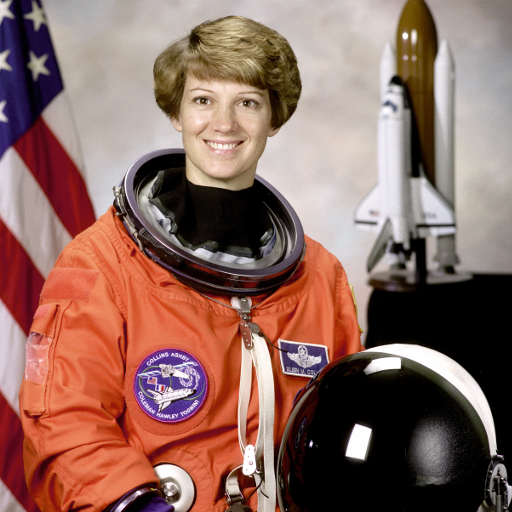

In [3]:
# load an image to use
import skimage
import numpy as np
from PIL import Image

image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert('RGB')
image

In [5]:
# directly pass the image
candidate_labels = ['human face', 'rocket', 'nasa badge', 'star-spangled banner']

predictions = detector(
    image,
    candidate_labels=candidate_labels
)
predictions

[{'score': 0.6007455587387085,
  'label': 'nasa badge',
  'box': {'xmin': 132, 'ymin': 348, 'xmax': 208, 'ymax': 423}},
 {'score': 0.5126086473464966,
  'label': 'nasa badge',
  'box': {'xmin': 278, 'ymin': 339, 'xmax': 329, 'ymax': 378}},
 {'score': 0.4519999921321869,
  'label': 'star-spangled banner',
  'box': {'xmin': 1, 'ymin': -1, 'xmax': 99, 'ymax': 505}},
 {'score': 0.2918585240840912,
  'label': 'rocket',
  'box': {'xmin': 352, 'ymin': 26, 'xmax': 465, 'ymax': 288}},
 {'score': 0.2252558469772339,
  'label': 'rocket',
  'box': {'xmin': 429, 'ymin': 40, 'xmax': 458, 'ymax': 260}},
 {'score': 0.20960155129432678,
  'label': 'star-spangled banner',
  'box': {'xmin': 7, 'ymin': 0, 'xmax': 512, 'ymax': 506}},
 {'score': 0.20486825704574585,
  'label': 'nasa badge',
  'box': {'xmin': 23, 'ymin': 330, 'xmax': 52, 'ymax': 384}},
 {'score': 0.19575101137161255,
  'label': 'rocket',
  'box': {'xmin': 395, 'ymin': -1, 'xmax': 438, 'ymax': 184}},
 {'score': 0.1818588674068451,
  'label': 

We see that there are detected results from our pipeline. Now we can visualize the predictions in the image.

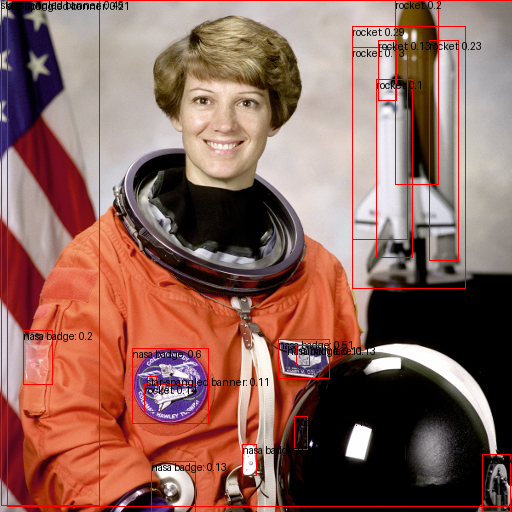

In [6]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

for pred in predictions:
    box = pred['box']
    label = pred['label']
    score = pred['score']

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle(
        (xmin, ymin, xmax, ymax),
        outline='red',
        width=1
    )
    draw.text(
        (xmin, ymin),
        f"{label}: {round(score, 2)}",
        fill='black'
    )

image

## Text-prompted zero-shot object detection by hand

Instead of using `pipeline`, we can manually load the model:

In [7]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

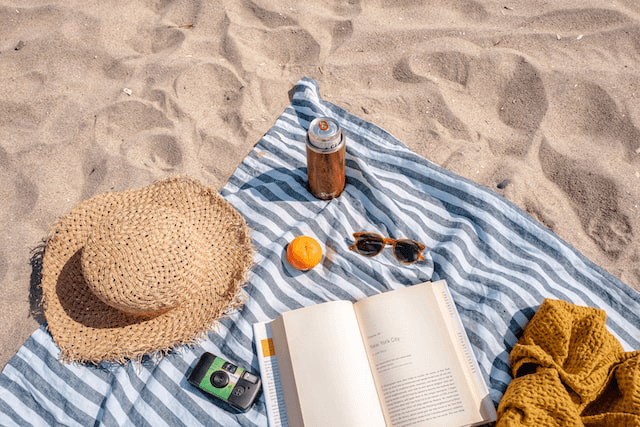

In [14]:
# try a different image
import requests

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_3.png"
img = Image.open(requests.get(url, stream=True).raw)
img = img.convert('RGB')
img

Use the processor to prepare the inputs for the model. The processor combines an image processor that prepares the image for the model by resizing and normalizing it, and a `CLIPTokenizer` that takes care of the text inputs.

In [15]:
text_queries = ['hat', 'book', 'sunglasses', 'camera']
inputs = processor(
    text=text_queries,
    images=[img],
    return_tensors='pt'
)

Now we can pass the `inputs` through the model, post-process, and visualize the results.

Since the image processor resized images before fedding them to the model, we need to use the `post_process_grounded_object_detection()` method to make sure the predicted bounding boxes have the correct coordinates relative to the original image:

In [17]:
import torch

with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([img.size[::-1]])
    results = processor.post_process_grounded_object_detection(
        outputs,
        threshold=0.1,
        target_sizes=target_sizes
    )[0]

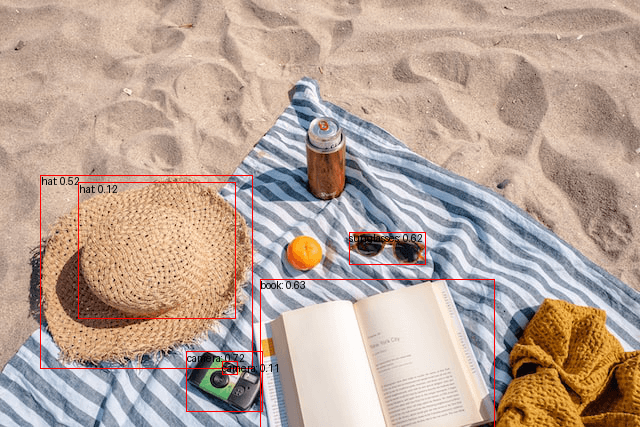

In [18]:
draw = ImageDraw.Draw(img)

scores = results['scores'].tolist()
labels = results['labels'].tolist()
boxes = results['boxes'].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle(
        (xmin, ymin, xmax, ymax),
        outline='red',
        width=1
    )
    draw.text(
        (xmin, ymin),
        f"{text_queries[label]}: {round(score, 2)}",
        fill='black'
    )

img

## Batch processing

We can pass multiple sets of images and text queries to search for different (or same) objects in several images.

In [19]:
images = [image, img] # astonaut image, beach image

# text queries as nested list
text_queries = [
    ['human face', 'rocket', 'nasa badge', 'star-spangled banner'],
    ['hat', 'book', 'sunglasses', 'camera']
]

inputs = processor(
    text=text_queries,
    images=images,
    return_tensors='pt'
)

Previously we passed the single image's size as a tensor for post-processing. For multiple images, we need to pass this as a list of tuples.

In [20]:
with torch.no_grad():
    outputs = model(**inputs)
    # get the target_sizes for all images
    target_sizes = [x.size[::-1] for x in images]
    results = processor.post_process_grounded_object_detection(
        outputs,
        threshold=0.1,
        target_sizes=target_sizes
    )

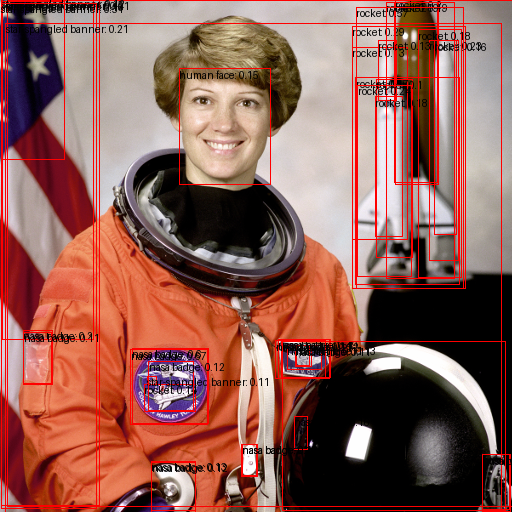

In [21]:
idx = 0
draw = ImageDraw.Draw(images[idx])

scores = results[idx]['scores'].tolist()
labels = results[idx]['labels'].tolist()
boxes = results[idx]['boxes'].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle(
        (xmin, ymin, xmax, ymax),
        outline='red',
        width=1
    )
    draw.text(
        (xmin, ymin),
        f"{text_queries[idx][label]}: {round(score, 2)}",
        fill='black'
    )
images[idx]

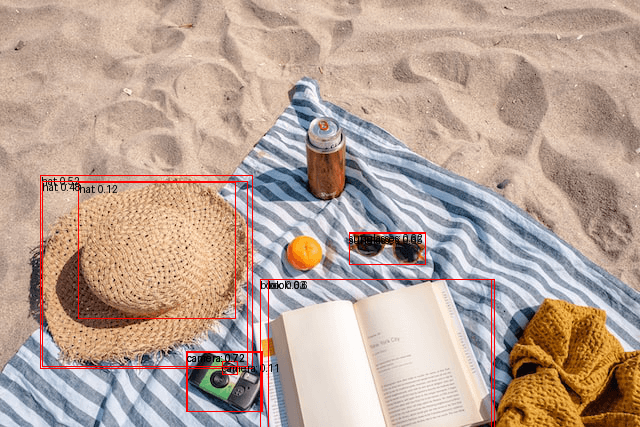

In [22]:
idx = 1
draw = ImageDraw.Draw(images[idx])

scores = results[idx]['scores'].tolist()
labels = results[idx]['labels'].tolist()
boxes = results[idx]['boxes'].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle(
        (xmin, ymin, xmax, ymax),
        outline='red',
        width=1
    )
    draw.text(
        (xmin, ymin),
        f"{text_queries[idx][label]}: {round(score, 2)}",
        fill='black'
    )
images[idx]

## Image-guided object detection

In addition to zero-shot object detection with text queries, OWL-ViT offers **image-guided object detection**, which means that we can use an image query to find similar objects in the target image.

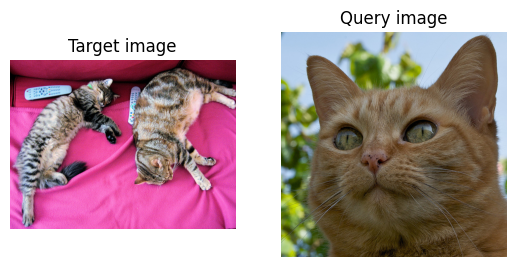

In [25]:
import matplotlib.pyplot as plt

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_target = Image.open(requests.get(url, stream=True).raw)
image_target = image_target.convert('RGB')

query_url = "http://images.cocodataset.org/val2017/000000524280.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)
query_image = query_image.convert('RGB')

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_target)
ax[1].imshow(query_image)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Target image')
ax[1].set_title('Query image')
plt.show()

In the preprocessing step, instead of text queries, we need to use `query_image`:

In [26]:
inputs = processor(
    images=image_target,
    query_images=query_image, # add here
    return_tensors='pt'
)

For predictions, instead of passing the inputs of the model, pass them to `image_guided_detection()`.

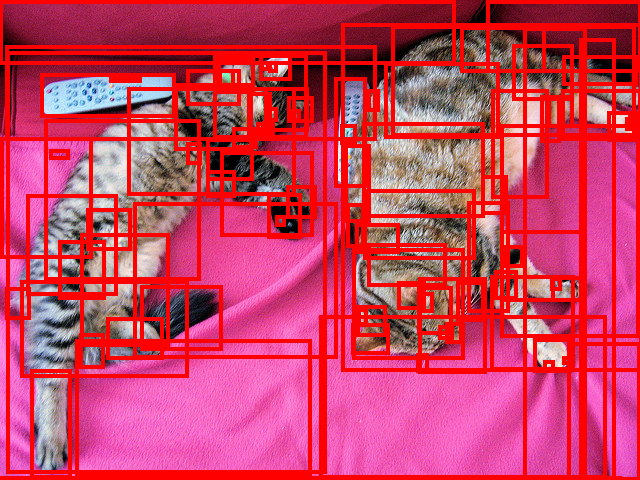

In [28]:
with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)
    target_sizes = torch.tensor([image_target.size[::-1]])
    results = processor.post_process_image_guided_detection(
        outputs=outputs,
        target_sizes=target_sizes
    )[0]

draw = ImageDraw.Draw(image_target)

scores = results['scores'].tolist()
boxes = results['boxes'].tolist()

for box, score in zip(boxes, scores):
    xmin, ymin, xmax, ymax = box
    draw.rectangle(
        (xmin, ymin, xmax, ymax),
        outline='red',
        width=4
    )

image_target